Page 1 

# CS 498 Applied Machine Learning - Homework 2

### Aaron Blythe
### Dan Barker

A screenshot of your best accuracy on the test set (retrieve this from the autograder).

| Aaron | Dan |
|---|---|
| ![best grade](best_grade.png) | ![best grade](dan_best_grade.png) |

\pagebreak

Page 2 A plot of the validation accuracy every 30 steps, for each value of the regularization constant. You should plot the curves for all regularization constants in the same plot using different colors with a label showing the corresponding values.


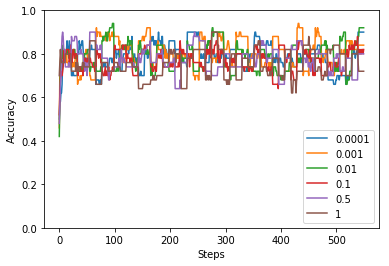

In [38]:
# Plot the accuracy as a function of step number
df = pd.DataFrame(plot_accuracy)
axes = plt.gca()
axes.set_ylim([0, 1])
plt.xlabel("Steps")
plt.ylabel("Accuracy")
for l in regularization_constants:
  plt.plot('x', "reg="+str(l), data=df)
plt.legend(regularization_constants)
plt.savefig('accuracy.png')

\pagebreak

Page 3 A plot of the magnitude of the coefficient vector every 30 steps, for each value of the regularization constant. You should plot the curves for all regularization constants in the same plot using different colors with a label showing the corresponding values.



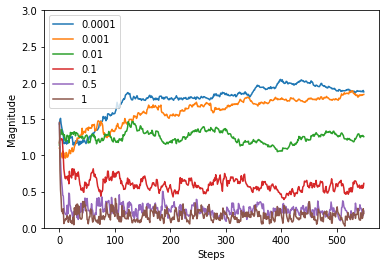

In [39]:
df2 = pd.DataFrame(plot_magnitude)
axes2 = plt.gca()
axes2.set_ylim([0, 3])
plt.xlabel("Steps")
plt.ylabel("Magnitude")
for l in regularization_constants:
  plt.plot('x', "reg="+str(l), data=df2)
plt.legend(regularization_constants, loc='upper left')
plt.savefig('magnitude.png')

\pagebreak

Page 4 

Our regularization constant was 0.01 as it was the most consistently accurate. 0.001 was also very close in accuracy, but it was less consistent in testing. 

We chose m = 1 and n = 50 for our learning rate (or more precisely step size). We found that making m = 2 and/or n = 100 - 150 gave very similar results. Numbers outside of these caused lower accuracy rates. 

From the text:

```
η (s) = m / (s+n) for constants m and n chosen by small-scale experiments. 
```

When we experimented with this, higher values for η (eta) (i.e. lower values for n) caused more erratic behavior where we were looking for a smoother curve

![comparison_of_eta](comparison_of_eta.png)

\pagebreak

Page 5 A screenshot of your code.

The page should contain snippets of code demonstrating:

* Training of an SVM, including but not limited to SGD.

```
def svm(regularizer):
  a = np.random.rand(6)
  b = np.random.rand(1)[0]
  for s in range(seasons):
    logging.debug("Season number: %s", s)
    stepsize = m / (s + n)
    rows = train.shape[0]
    idx = np.arange(0, rows)
    np.random.shuffle(idx)
    eval_idx = idx[:held_out]
    train_idx = idx[held_out:]
    this_train = train[train_idx]
    this_yi = labels[train_idx]
    this_test = train[eval_idx]
    this_label = labels[eval_idx]
    for k in range(season_steps):
      uni_rand = np.random.choice(range(len(this_train)), 1)[0]
      xi = this_train[uni_rand]
      yi = this_yi[uni_rand]
      gi = yi * (np.dot(a, xi.T) + b)
      if gi >= 1:
        a = a - (stepsize * regularizer * a)
      else:
        a = a - (stepsize * ((regularizer * a) - (yi * xi)))
        b = b + (stepsize * yi)
      if (k % accuracy_steps == 0):
        predictions = predict(this_test, a, b)
        step_accuracy = calculate_accuracy(predictions, this_label)
        list_accuracy.append(step_accuracy)
        list_magnitude.append(np.linalg.norm(a))
```

* Testing of an SVM.

```
test_output = []
for it_y in range(len(test)):
  if best_a.dot(test[it_y, :]) + best_b > 0:
    test_output.append('>50K')
  else:
    test_output.append('<=50K')
test_output = np.array(test_output)
np.savetxt("submission.txt", test_output, delimiter="", fmt='%s')
logging.info(test_output)
```

\pagebreak

Page 6 

All code should be attached at the end of the pdf.  There is no limit to the number of pages required for full code printout.

In [26]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
# for debugging output
import logging, sys
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
#logger.setLevel(logging.WARNING)

In [27]:
train_raw = pd.read_csv('https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/train.txt', sep=",", header=None)
train_raw.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
                'race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']
test_raw = pd.read_csv('https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test.txt', sep=",", header=None)
test_raw.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
                'race','sex','capital-gain','capital-loss','hours-per-week','native-country']

In [33]:
# You should scale these variables so that each has unit variance, and you should subtract the mean so that each has zero mean.
def scale(data):
  data = data - np.mean(data, axis=0)
  data = data / np.std(data, axis=0)
  return data

raw_labels = train_raw['label']
labels = []
for lab in raw_labels:
  if lab == raw_labels[0]:
    labels.append(-1)
  else:
    labels.append(1)
labels = np.array(labels)
# You should use only the continuous variables as a feature vector.
# https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
continuous_variables = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
train = train_raw[continuous_variables].values
test = test_raw[continuous_variables].values
train = scale(train)
test = scale(test)

# You should search for an appropriate value of the regularization constant, trying at least the values [1e-3, 1e-2, 1e-1, 1].
regularization_constants = [1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1]
# Use 10% of your training data as a validation set for this search.
validation_proportion = 0.1

# You should use at least 50 seasons of at least 300 steps each.
seasons = 50
season_steps = 300
# In each season, you should separate out 50 training examples at random for evaluation (call this the set held out for the season).
held_out = 50
# You should compute the accuracy of the current classifier on the held out set for the season every 30 steps. 
accuracy_steps = 30

# Variables for learning rate/stepsize
# Answer the question: What was your choice for the learning rate and why did you choose it?
m = 1.0
n = 50

In [29]:
def predict(tests, a, b):
  sign = np.dot(tests, a.T) + b
  sign[sign <= 0] = -1
  sign[sign > 0] = 1
  return sign

In [30]:
def calculate_accuracy(preds, labels):
  match = 0
  for prediction, actual in zip(preds, labels):
    if prediction == actual: match += 1 
  return match / len(labels)

In [31]:
list_accuracy = []
list_magnitude = []
def svm(regularizer):
  # Choose a random start point.
  a = np.random.rand(6)
  b = np.random.rand(1)[0]
  # Now iterate:
  for s in range(seasons):
    logging.debug("Season number: %s", s)

    # Update the stepsize (learning rate)
    stepsize = m / (s + n)

    # Split the training dataset into a training part and a validation part. This split changes each season.
    rows = train.shape[0]
    idx = np.arange(0, rows)
    np.random.shuffle(idx)
    eval_idx = idx[:held_out]
    train_idx = idx[held_out:]
    this_train = train[train_idx]
    this_yi = labels[train_idx]
    this_test = train[eval_idx]
    this_label = labels[eval_idx]

    # Take k steps.
    for k in range(season_steps):
      # Each step is taken by selecting a batch of Nb data items uniformly and at random from the training part for that season.
      uni_rand = np.random.choice(range(len(this_train)), 1)[0]
      xi = this_train[uni_rand]
      yi = this_yi[uni_rand]
      # and update the model by computing u (n+1) = u (n) + ηp (n)
      # remember u = (a,b)
      gi = yi * (np.dot(a, xi.T) + b)
      if gi >= 1:
        a = a - (stepsize * regularizer * a)
      else:
        a = a - (stepsize * ((regularizer * a) - (yi * xi)))
        b = b + (stepsize * yi)

      # Evaluate the current model u (n) by computing the accuracy on the validation part for that season. .
      if (k % accuracy_steps == 0):
        predictions = predict(this_test, a, b)
        step_accuracy = calculate_accuracy(predictions, this_label)
        list_accuracy.append(step_accuracy)
        list_magnitude.append(np.linalg.norm(a))
        logging.debug("Step number %s has season accuracy of: %s", k, step_accuracy)

    predictions = predict(this_test, a, b)
    season_accuracy = calculate_accuracy(predictions, this_label)
    list_accuracy.append(season_accuracy)
    list_magnitude.append(np.linalg.norm(a))
    mean_accuracy = np.mean(np.array(list_accuracy))
    logging.debug("Season accuracy for %s is %s", s, season_accuracy)
    logging.debug("Standard deviation: %s", np.std(np.array(list_accuracy)))
  return a, b, season_accuracy

In [34]:
start_time = str(datetime.datetime.now().time())
logging.info("Start time: %s", start_time)
plot_accuracy = {}
plot_magnitude = {}
best_a = np.array([0,0,0,0,0,0])
best_b = 1.0
best_regularizer = 0
best_accuracy = 0
for rc in regularization_constants:
  logging.info("Regularization Constant: %s started at: %s", rc, str(datetime.datetime.now().time()))
  list_accuracy = []
  list_magnitude = []
  a, b, cur_accuracy = svm(rc)
  predictions = predict(test, a, b)
  plot_accuracy["reg="+str(rc)] = list_accuracy
  plot_magnitude["reg="+str(rc)] = list_magnitude
  if cur_accuracy > best_accuracy:
    best_a = a
    best_b = b
    best_accuracy = cur_accuracy
    best_regularizer = rc
      
plot_magnitude['x'] = range(len(list_accuracy))
plot_accuracy['x'] = range(len(list_magnitude))
logging.info("Start time: %s Finish time: %s", start_time, str(datetime.datetime.now().time()))
logging.info("Best regularizer: %s with: %s Accuracy", best_regularizer, best_accuracy)

INFO:root:Start time: 22:02:12.527073
INFO:root:Regularization Constant: 0.0001 started at: 22:02:12.528502
INFO:root:Regularization Constant: 0.001 started at: 22:03:37.626654
INFO:root:Regularization Constant: 0.01 started at: 22:05:04.978438
INFO:root:Regularization Constant: 0.1 started at: 22:06:34.291378
INFO:root:Regularization Constant: 0.5 started at: 22:08:06.309596
INFO:root:Regularization Constant: 1 started at: 22:09:39.578042
INFO:root:Start time: 22:02:12.527073 Finish time: 22:11:14.536052
INFO:root:Best regularizer: 0.01 with: 0.92 Accuracy


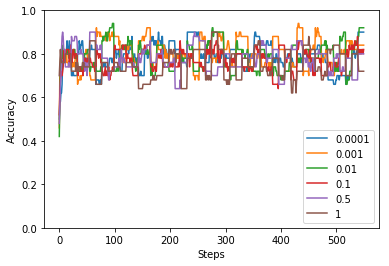

In [35]:
# Plot the accuracy as a function of step number
df = pd.DataFrame(plot_accuracy)
axes = plt.gca()
axes.set_ylim([0, 1])
plt.xlabel("Steps")
plt.ylabel("Accuracy")
for l in regularization_constants:
  plt.plot('x', "reg="+str(l), data=df)
plt.legend(regularization_constants)
plt.savefig('accuracy.png')

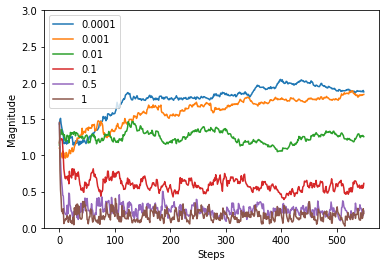

In [36]:
df2 = pd.DataFrame(plot_magnitude)
axes2 = plt.gca()
axes2.set_ylim([0, 3])
plt.xlabel("Steps")
plt.ylabel("Magnitude")
for l in regularization_constants:
  plt.plot('x', "reg="+str(l), data=df2)
plt.legend(regularization_constants, loc='upper left')
plt.savefig('magnitude.png')

In [37]:
# Once you have trained your final classifier, score the provided test set, recording the results in a file with the same format as submission.txt.  
# You will be able to submit this result to gradescope repeatedly for scoring.

test_output = []
for it_y in range(len(test)):
  if best_a.dot(test[it_y, :]) + best_b > 0:
    test_output.append('>50K')
  else:
    test_output.append('<=50K')
test_output = np.array(test_output)
# https://stackoverflow.com/questions/6081008/dump-a-numpy-array-into-a-csv-file
np.savetxt("submission.txt", test_output, delimiter="", fmt='%s')
#pd.DataFrame(test_output).to_csv("submission.txt")
logging.info(test_output)

INFO:root:['<=50K' '<=50K' '<=50K' ... '<=50K' '<=50K' '<=50K']


\pagebreak

Procedure: 4.3 Training an SVM: stochastic gradient descent 

Obtain `u = (a, b)` by stochastic gradient descent on the cost function 

    g(u) = [ (1/N) Σi=1->N gi(u) ] + g0(u) 

where g0(u) = λ(a T a)/2 and gi(u) = max(0, 1 − yi  a T xi + b  ). Do so by first choosing a fixed number of items per batch Nb, the number of steps per season Ns, and the number of steps k to take before evaluating the model (this is usually a lot smaller than Ns). Choose a random start point. 

Now iterate: 

* Update the stepsize. In the s’th season, the step size is typically η (s) = m s+n for constants m and n chosen by small-scale experiments. 
* Split the training dataset into a training part and a validation part. This split changes each season. Use the validation set to get an unbiased estimate of error during that season’s training. 
* Now, until the end of the season (i.e. until you have taken Ns steps): 
  *  Take k steps. Each step is taken by selecting a batch of Nb data items uniformly and at random from the training part for that season. Write D for this set. Now compute 
     
     p (n) = − 1 Nb X i∈D ∇gi(u (n) ) ! − λu (n) , 

and update the model by computing 

    u (n+1) = u (n) + ηp (n) 

  * Evaluate the current model u (n) by computing the accuracy on the validation part for that season. Plot the accuracy as a function of step number. 

There are two ways to stop. You can choose a fixed number of seasons (or of epochs) and stop when that is done. Alternatively, you can watch the error plot and stop when the error reaches some level or meets some criterion.

(Page 43). 

From the homework assignment: 

![From the homework](https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/svm_gradient.gif)

\pagebreak